In [1]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import *
import cv2# from scipy.misc import imresize
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from subprocess import check_output
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# set the necessary directories
data_dir = "train/"
mask_dir = "train_masks/"
all_images = os.listdir(data_dir)

In [3]:
# pick which images we will use for testing and which for validation
train_images, test_images = train_test_split(all_images, train_size=0.8, test_size=0.2)

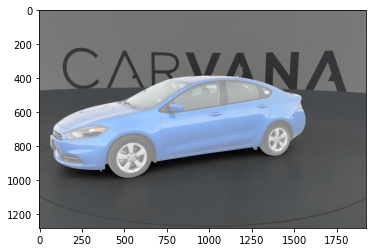

In [38]:
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                array_img = img_to_array(original_img)/255
                resized_img = cv2.resize(array_img, (dims[1], dims[0]))
                imgs.append(resized_img)

                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                array_mask = img_to_array(original_mask)/255
                resized_mask = cv2.resize(array_mask, (dims[1], dims[0]), interpolation=cv2.INTER_AREA)
                labels.append(resized_mask[:, :, 0:1])
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels

# example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, 1, [1280, 1920])
test_gen = data_gen_small(data_dir, mask_dir, test_images, 1, [1280, 1920])
img, msk = next(train_gen)
img, msk = next(test_gen)
plt.imshow(img[0])
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [39]:
def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

# Now let's use Tensorflow to write our own dice_coeficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1280, 1920,  0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 1280, 1920, 6 1792        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 1280, 1920, 6 36928       conv2d_114[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 640, 960, 64) 0           conv2d_115[0][0]                 
____________________________________________________________________________________________

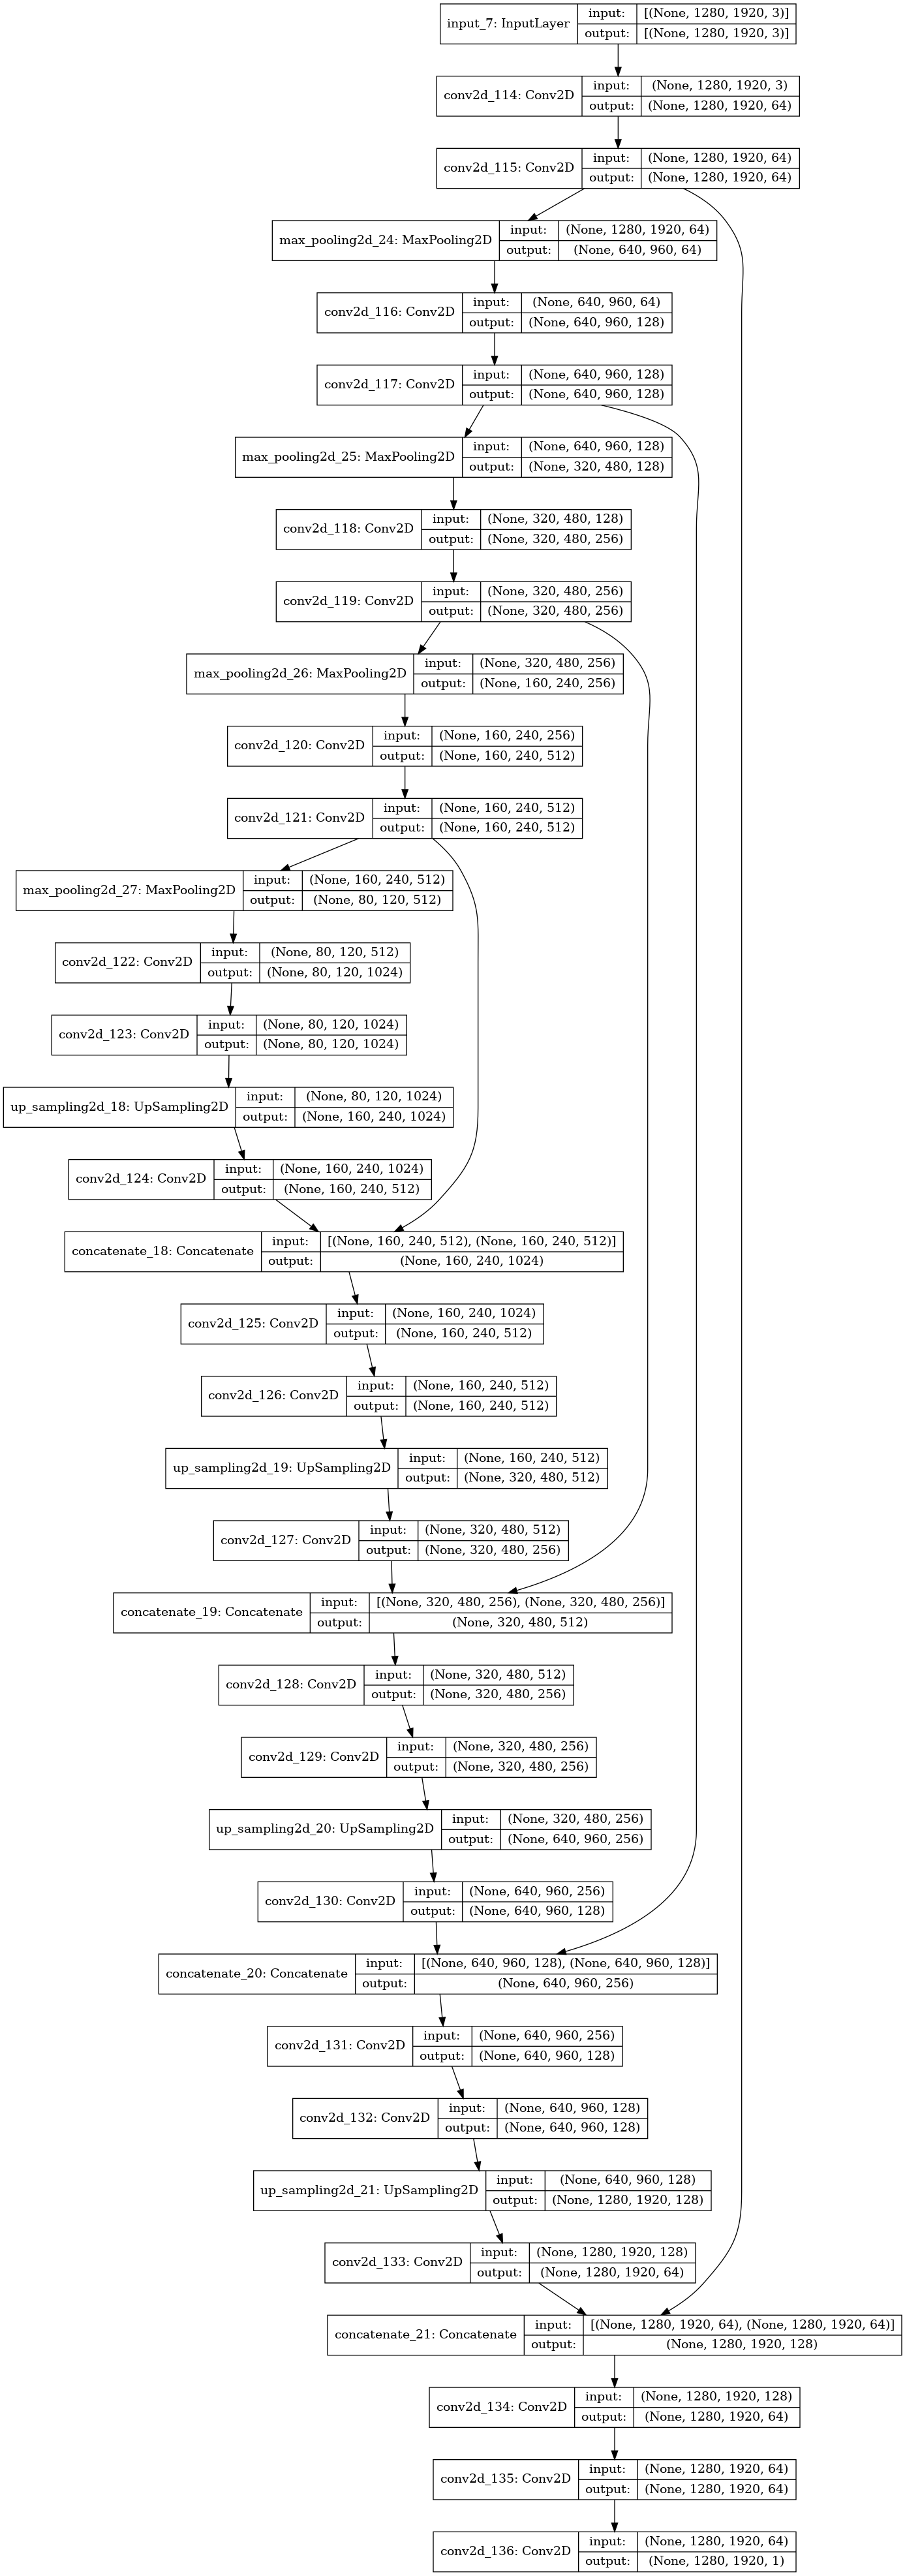

In [40]:
# Make a custom U-nets implementation.
filters = 64
input_layer = Input(shape = [1280, 1920, 3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

# Down 2, 64
d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

# Down 3, 32
d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

# Down 4, 16
d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

# Down 5, 8
d5 = down(d4, filters, pool=False)

# Up 1, 16
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

# Up 2,  32
up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

# Up 3, 64
up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

# Up 4, 128
up4 = up(up3, residual=residuals[-4], filters=filters/2)

out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()
tf.keras.utils.plot_model(model, to_file='U_net_model.png', show_shapes=True)

In [41]:
# probably need to play around a little bit with the learning rate to get it to start learning
path ='Carvana_training/'
filepath = path + '{epoch:04d}-train_{loss:f}-test_{val_loss:f}.h5'
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 120, verbose = 0)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.2, patience = 30,
                              min_lr = 2e-7,verbose = 0)   

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='auto')    
callbacks_list = [earlystopper,reduce_lr,checkpoint]
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics = [dice_coef])
history = model.fit_generator(train_gen, validation_data = test_gen, steps_per_epoch = 500, validation_steps = 50, 
                              epochs = 50, callbacks = callbacks_list, verbose = 1)   

/media/disk1/weisting/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
500/500 [==============================] - 268s 534ms/step - loss: 0.3120 - dice_coef: 0.5162 - val_loss: 0.1731 - val_dice_coef: 0.8085
Epoch 2/50
500/500 [==============================] - 269s 537ms/step - loss: 0.1199 - dice_coef: 0.8893 - val_loss: 0.0998 - val_dice_coef: 0.9123
Epoch 3/50
500/500 [==============================] - 268s 536ms/step - loss: 0.0949 - dice_coef: 0.9146 - val_loss: 0.0575 - val_dice_coef: 0.9542
Epoch 4/50
500/500 [==============================] - 268s 536ms/step - loss: 0.0655 - dice_coef: 0.9443 - val_loss: 0.0398 - val_dice_coef: 0.9663
Epoch 5/50
500/500 [==============================] - 268s 536ms/step - loss: 0.0495 - dice_coef: 0.9601 - val_loss: 0.0512 - val_dice_coef: 0.9581
Epoch 6/50
500/500 [==============================] - 268s 536ms/step - loss: 0.0530 - dice_coef: 0.9570 - val_loss: 0.0450 - val_dice_coef: 0.9656
Epoch 7/50
500/500 [==============================] - 268s 537ms/step - loss: 0.0344 - dice_coef: 0.9716 - val_l

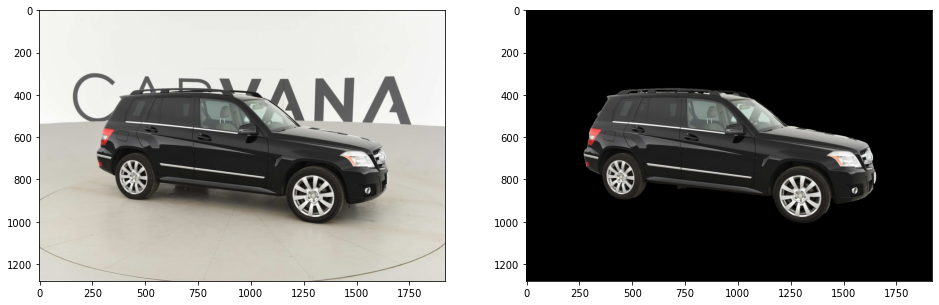

In [68]:
original_img = load_img(data_dir + test_images[501])
array_img = img_to_array(original_img)/255
resized_img = cv2.resize(array_img, (1920, 1280)) # x and y inverse
pred = model.predict(np.reshape(resized_img,(1,1280,1920,3)))[0,:,:,0]

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(resized_img)
plt.subplot(122)
plt.imshow(cv2.bitwise_and(resized_img, resized_img, mask = np.array(np.round(pred,0),dtype=np.uint8)))
plt.show()